<center>

# **📘 Patent Classification - Task 1**



</center>

In this notebook, we explore the task of **patent classification**, a multi-class document classification problem where the objective is to automatically assign a patent document—typically its full text or abstract—to one of several predefined **technology categories**. 


We will begin by understanding the problem context, surveying the current state of the art, and examining the dataset in detail. We will then establish simple baselines—including a random and a rule-based classifier—to set reference points for future model evaluation.


### **Outline**
---


1. [🔧 Load and Preview Dataset](#part1)
2. [📊 Dataset Description](#part1)  
3. [🎲 Random Classifier Benchmark](#part1)
4. [📏 Rule-Based Classifier](#part1)  
5. [🧩 Summary and Key Observations](#part1)




In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math
from collections import Counter
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from staticvectors import StaticVectors
from tqdm import tqdm

from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from staticvectors import StaticVectors
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping


palette = sns.color_palette("Spectral", 9)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [25]:
class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self, custom_palette=None):
        # Default color palette
        methods = list(self.results.keys())
        if custom_palette is None:
            custom_palette = sns.color_palette("Spectral", n_colors=len(methods))

        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

        for i, metric in enumerate(metric_names):
            ax = axs[i // 2, i % 2]
            values = [self.results[m][metric.lower()] * 100 for m in methods]
            
            # Plot bars
            ax.bar(methods, values, color=custom_palette)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Annotate bars
            for j, v in enumerate(values):
                ax.text(j, v + 1, f"{v:.2f}", ha='center', va='bottom')

            # Rotate x-axis labels
            ax.set_xticks(range(len(methods)))
            ax.set_xticklabels(methods, rotation=45)

            # Style spines
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # Style ticks
            ax.tick_params(axis='y', colors='black', direction='in', length=5, width=1)
            ax.tick_params(axis='x', colors='black', direction='in', length=5, width=1)

        plt.tight_layout()
        plt.show()


# **1. Load the Dataset**

We will use the `ccdv/patent-classification` dataset from the Hugging Face Hub, which contains **35,000 U.S. patents**, including both their full texts and abstracts, annotated with **classification labels**. Each patent is assigned to one of **nine distinct technical categories** based on its content.

This dataset is derived from the **BIGPATENT** corpus, which was originally constructed for summarization tasks. It contains full-text patent documents and human-written summaries sourced from the **Google Patents Public Datasets** via BigQuery (Google, 2018). While BIGPATENT was primarily intended for abstractive summarization, in this study we repurpose it for the task of **patent classification**.


In [26]:
splits = {'train': 'abstract/train-00000-of-00001.parquet', 'validation': 'abstract/validation-00000-of-00001.parquet', 'test': 'abstract/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/ccdv/patent-classification/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/ccdv/patent-classification/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/ccdv/patent-classification/" + splits["test"])

Why having 3 dataset is benefitial for our model?

Using three datasets (train, dev, test) helps prevent overfitting and ensures better generalization. The dev set allows tuning and model selection without leaking information from the test set.


# **2. Dataset Description**
---
This section aims to provide a brief overview of our dataset, including size, class distribution, and any peculiar characteristics. 

### **Distribution of labels**

Let's see the distribution of the labels in the datasets, to know if we are dealing with a balanced dataset or not, and based on that taking into account which metric should be the adecuate the evaluate the performance of the model.


In [27]:
label_map = {
    '0': "Human Needs",
    '1': "Operations & Transport",
    '2': "Chemistry & Metallurgy",
    '3': "Textiles & Paper",
    '4': "Construction",
    '5': "Mechanical & Thermal Engineering",
    '6': "Physics",
    '7': "Electricity",
    '8': "Cross-Tech Tagging"
}
df_train['label_name'] = df_train['label'].astype(str).map(label_map)
df_val['label_name'] = df_val['label'].astype(str).map(label_map)
df_test['label_name'] = df_test['label'].astype(str).map(label_map)

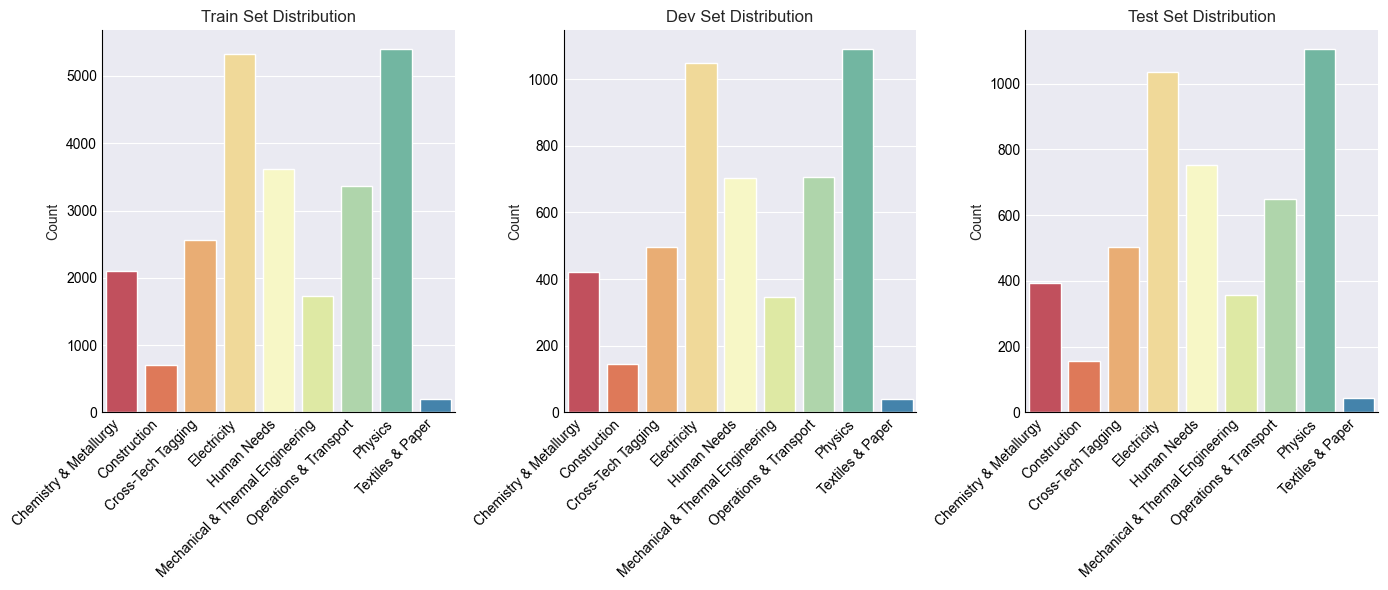

In [28]:
# Step 1: Define consistent order of labels
label_order = sorted(set(df_train['label_name']) | set(df_val['label_name']) | set(df_test['label_name']))

# Step 2: Create a consistent color palette
palette_colors = sns.color_palette("Spectral", n_colors=len(label_order))
palette_dict = dict(zip(label_order, palette_colors))

# Step 3: Plot with consistent order and palette
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

for i, (df, label) in enumerate(zip([df_train, df_val, df_test], ['Train', 'Dev', 'Test'])):
    sns.countplot(
        data=df,
        x='label_name',
        hue='label_name',
        ax=axs[i],
        order=label_order,
        palette=palette_dict,
        legend=False
    )
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
    axs[i].set_title(f'{label} Set Distribution')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')
    # Style spines
    axs[i].spines['bottom'].set_color('black')
    axs[i].spines['left'].set_color('black')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    # Style ticks
    axs[i].tick_params(axis='y', colors='black', direction='in', length=5, width=1)
    axs[i].tick_params(axis='x', colors='black', direction='in', length=5, width=1)

plt.tight_layout()
plt.show()


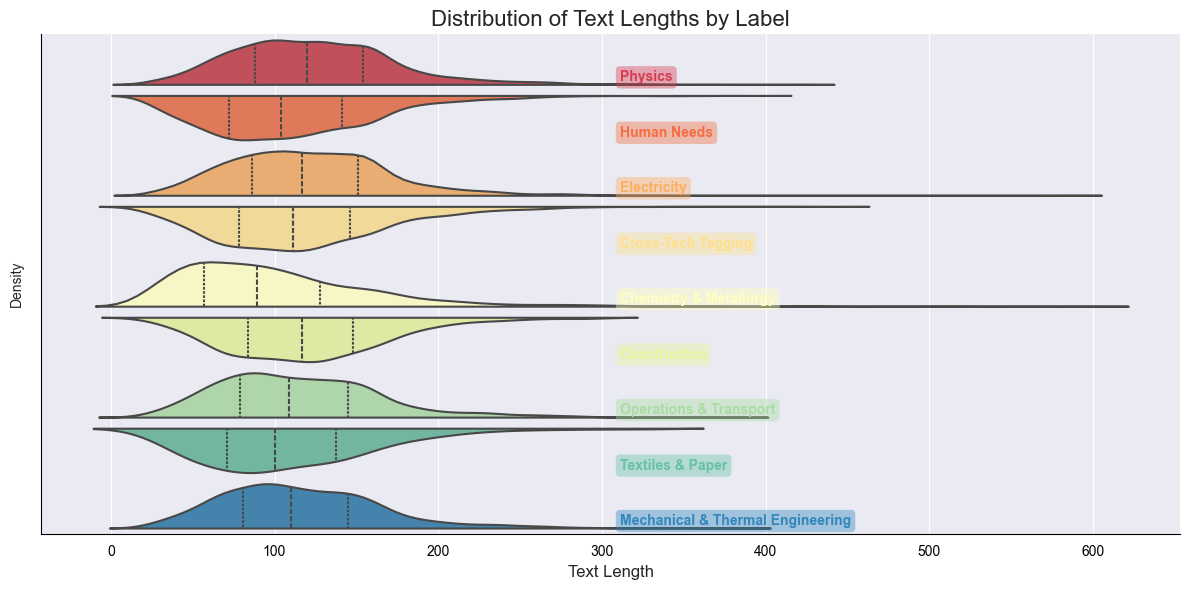

In [29]:
#generate text_lenght column
df_train["text_lenght"] = df_train["text"].apply(lambda x: len(x.split()))
df_train['text_lenght'] = pd.to_numeric(df_train['text_lenght'], errors='coerce')

# Create plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    data=df_train,
    y="label_name",
    x="text_lenght",
    inner="quartile",
    palette="Spectral",
    fill=True,
    linewidth=1.5,
    split=True,
    hue="label_name"
)

y_labels = df_train['label_name'].unique()
y_ticks = range(len(y_labels))

colors = sns.color_palette("Spectral", len(y_labels))

for y, label, color in zip(y_ticks, y_labels, colors):
    ax.text(
        x=df_train['text_lenght'].median()+200,  # Horizontal placement, you can adjust
        y=y+0.4,
        s=label,
        ha='left',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color=color,
        bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3', alpha=0.4)
    )
#hide the y axis
ax.set_yticklabels([])
ax.set_ylabel('Density')
ax.set_xlabel('Text Length', fontsize=12)
ax.set_title('Distribution of Text Lengths by Label', fontsize=16)
# Style spines
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Style ticks
ax.tick_params(axis='y', colors='black', direction='out', length=5, width=1)
ax.tick_params(axis='x', colors='black', direction='out', length=5, width=1)

plt.tight_layout()
plt.show()


In [30]:
# ============ Cleaning functions ============
def remove_special_characters(text):
    text = re.sub(r'[^A-Za-z\s]', '', text.lower())
    return text

def remove_stopwords_tokenize(text, stop_words_set):
    text = [word for word in text.split() if word not in stop_words_set and len(word) > 1]
    return text

def get_clean_tokens_list(texts, stop_words_set):
    all_words = []
    for txt in texts:
        txt = remove_special_characters(txt)
        txt = remove_stopwords_tokenize(txt, stop_words_set)
        all_words.extend(txt)
    return all_words

# ============ Plot function ============
def plot_wordclouds_by_class(df, stop_words_set, text_column='text', label_column='label', label_name_column='label_name', cmap='Spectral'):
    unique_labels = sorted(df[label_column].unique())
    n_classes = len(unique_labels)

    cols = 3
    rows = (n_classes + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5))
    axs = axs.flatten()

    for i, label in enumerate(unique_labels):
        texts = df[df[label_column] == label][text_column].values
        tokens = get_clean_tokens_list(texts, stop_words_set)
        # Convert list of tokens to frequency dict
        token_freq = dict(Counter(tokens))

        wc = WordCloud(width=800, height=250, background_color='white', colormap=cmap, random_state=42).generate_from_frequencies(token_freq)

        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].axis('off')

        label_name = df[df[label_column] == label][label_name_column].iloc[0]
        axs[i].set_title(label_name, fontsize=14)

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout(pad=0.01)
    plt.show()

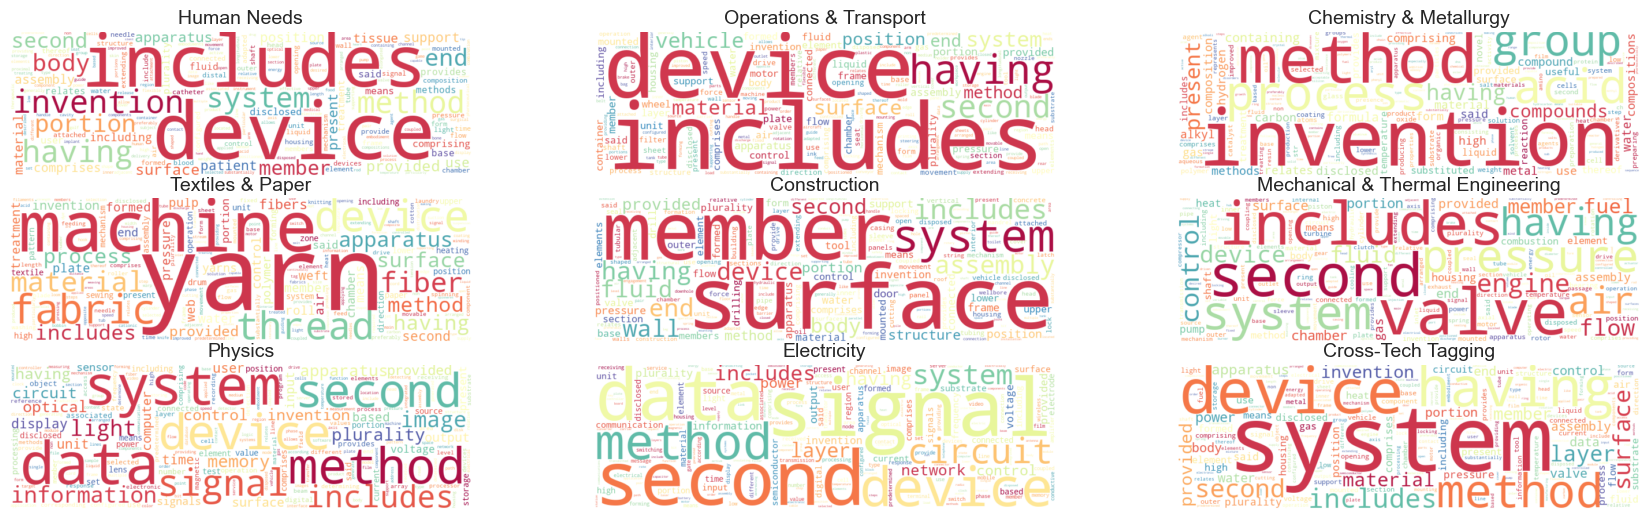

In [31]:
# Base stopwords (assumed from spacy)
stop_words = set(spacy_stopwords)
plot_wordclouds_by_class(df_train, stop_words)

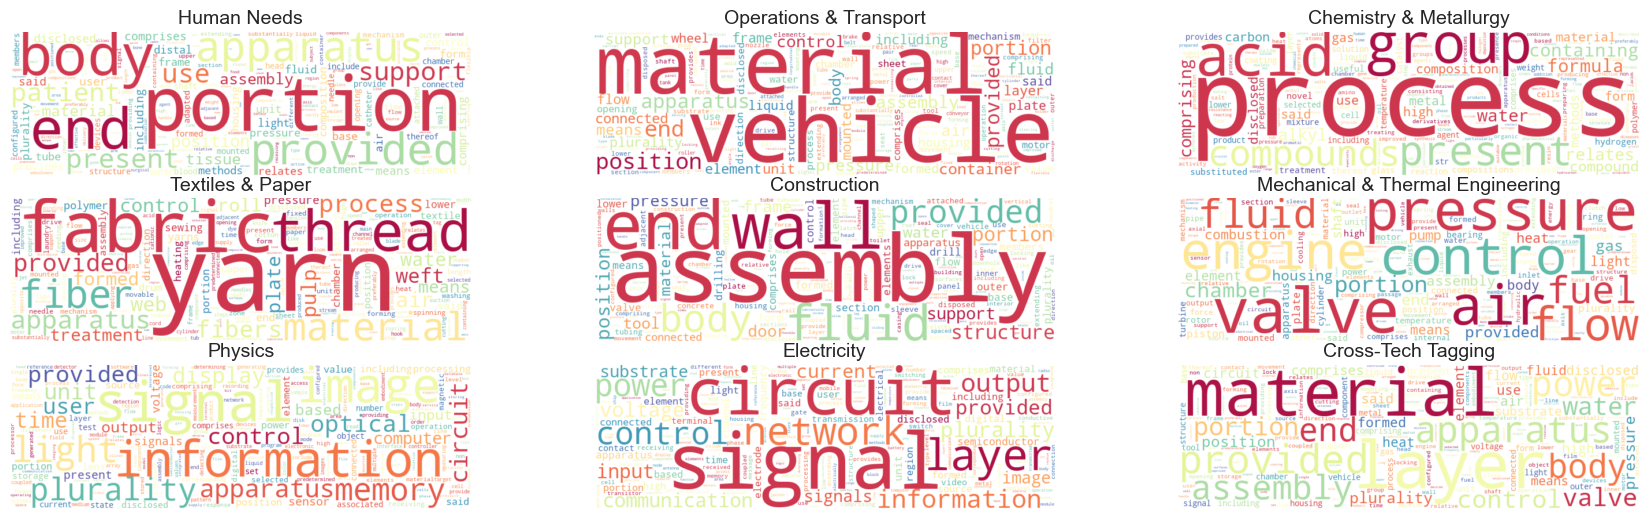

In [32]:
generic_words_patents = {"fig", "fabric", "example", "shown", "invention", "provided", "provide", 
                 "present", "material", "corresponding", "referring", "include", 'second', 'case', 'use', 'form',
                 'set', 'portion', 'embodiment', 'position', 'surface', 'means', 'preferably', 'respectively', 
                 'section', 'opening', 'component', 'function', 'operation',
                 'result', 'results', 'end', 'time', "data", "member", "described"}
generic_words_abstracts = {'includes', 'device', 'machine', 'member', 'surface', 'invention', 'second', 'fabricant',
                           'system', 'having', 'data', 'method'}
plot_wordclouds_by_class(df_train, stop_words.union(generic_words_abstracts))

In [33]:
# --- Plot 4: TF-IDF Keywords by class ---
top_n = 10
corpus = df_train["text"]
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(X.toarray(), columns=features)
tfidf_df["label"] = df_train["label"]

keywords_per_class = {}
for label in df_train["label"].unique():
    mean_tfidf = tfidf_df[tfidf_df["label"] == label].drop(columns="label").mean()
    top_keywords = mean_tfidf.sort_values(ascending=False).head(top_n)
    label_name = label_map.get(str(label), f"Label {label}")
    keywords_per_class[label_name] = top_keywords.index.tolist()


keywords_df = pd.DataFrame.from_dict(keywords_per_class, orient="index").T
keywords_df.columns.name = "Class"
keywords_df.index.name = "Top Keywords"
keywords_df.reset_index(inplace=True)

keywords_df.head()

Class,Top Keywords,Physics,Human Needs,Electricity,Cross-Tech Tagging,Chemistry & Metallurgy,Construction,Operations & Transport,Textiles & Paper,Mechanical & Thermal Engineering
0,0,data,invention,signal,device,invention,surface,vehicle,machine,valve
1,1,method,device,data,method,compounds,assembly,material,fibers,engine
2,2,device,body,circuit,having,acid,member,device,fabric,pressure
3,3,signal,portion,second,surface,process,wall,surface,fiber,air
4,4,image,patient,layer,material,formula,end,having,process,fuel


# **3. Random Classifier Performance**
---
In this section we will calculate the expected performance of a random classifier for out dataset to set a benchmark.

In [34]:
# Set some hyperparameter settings for Tf-Idf
tfidf_params = {
    "stop_words": "english",                                       
    "min_df": 0.01,                       
    "max_df": 0.95,                     
    "ngram_range": (1, 3),             
    "max_features": 1000             
}

# Create the pipeline
pipeline = Pipeline([
    ("preprocessor", FunctionTransformer(lambda X: [remove_special_characters(text) for text in X])),
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    ("logreg", LogisticRegression(
         random_state=42,
         C=1.0,
         penalty='l2',
         solver='lbfgs',
         max_iter=1000,
         class_weight='balanced'
     ))
])

#Train the model
pipeline.fit(df_train["text"], df_train["label"])

# Evaluate on dev set
y_dev_pred = pipeline.predict(df_val["text"])
y_dev_true = df_val['label']
results = Metrics()
results.run(y_dev_true, y_dev_pred, 'tfidf-lr_dev')

# Test on test set
y_test_pred = pipeline.predict(df_test['text'])
y_test_true = df_test['label']
results.run(y_test_true, y_test_pred, 'tfidf-lr_test')

In [35]:
tfidf_params = {
    "stop_words": "english",                                       
    "min_df": 1,                       
    "max_df": 0.8,                     
    "ngram_range": (1, 2),             
    "max_features": 500              
}

# Create the pipeline
pipeline = Pipeline([
    ("preprocessor", FunctionTransformer(lambda X: [remove_special_characters(text) for text in X])),
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    ("randomtreec", RandomForestClassifier(
        n_estimators=500,
        max_depth=50,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        class_weight='balanced'    
     ))
])

#Train the model
pipeline.fit(df_train["text"], df_train["label"])

# Evaluate on dev set
y_dev_pred = pipeline.predict(df_val["text"])
y_dev_true = df_val['label']
results.run(y_dev_true, y_dev_pred, 'tfidf-rf_dev')

# Test on test set
y_test_pred = pipeline.predict(df_test['text'])
y_test_true = df_test['label']
results.run(y_test_true, y_test_pred, 'tfidf-rf_test')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finis

In [36]:
class StemTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return [' '.join([self.stemmer.stem(word) for word in text.split()]) for text in X]

# Update pipeline to include stemming
pipeline = Pipeline([
    ("preprocessor", FunctionTransformer(lambda X: [remove_special_characters(text) for text in X])),
    ('stemmer', StemTransformer()),
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('logreg', LogisticRegression(random_state=42,
         C=1.0,
         penalty='l2',
         solver='lbfgs',
         max_iter=1000,
         class_weight='balanced'))
])


#Train the model
pipeline.fit(df_train["text"], df_train["label"])

# Evaluate on dev set
y_dev_pred = pipeline.predict(df_val["text"])
y_dev_true = df_val['label']
results.run(y_dev_true, y_dev_pred, 'stemmed_tfidf-lr_dev')

# Test on test set
y_test_pred = pipeline.predict(df_test['text'])
y_test_true = df_test['label']
results.run(y_test_true, y_test_pred, 'stemmed_tfidf-lr_test')

In [37]:
# Load StaticVectors model
print("Loading Word2Vec model...")
word2vec_model = StaticVectors("neuml/word2vec")


def get_word2vec_embedding(text: str) -> np.ndarray:
    results = []
    for word in text.split():
        embedding = word2vec_model.embeddings([word])
        if embedding is not None and len(embedding) > 0:
            results.append(embedding[0])
    if results:
        return np.mean(results, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)
    
    
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def _init_(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([get_word2vec_embedding(text) for text in X])



mean_pipeline = make_pipeline(
    FunctionTransformer(lambda X: [remove_special_characters(text) for text in X]),
    MeanEmbeddingVectorizer(),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)

mean_pipeline.fit(df_train['text'], df_train['label'])
y_pred_mean = mean_pipeline.predict(df_val['text'])
y_pred_mean_test = mean_pipeline.predict(df_test['text'])
results.run(df_val['label'], y_pred_mean, "mean_w2v_dev")
results.run(df_test['label'], y_pred_mean_test, "mean_w2v_test")

Loading Word2Vec model...


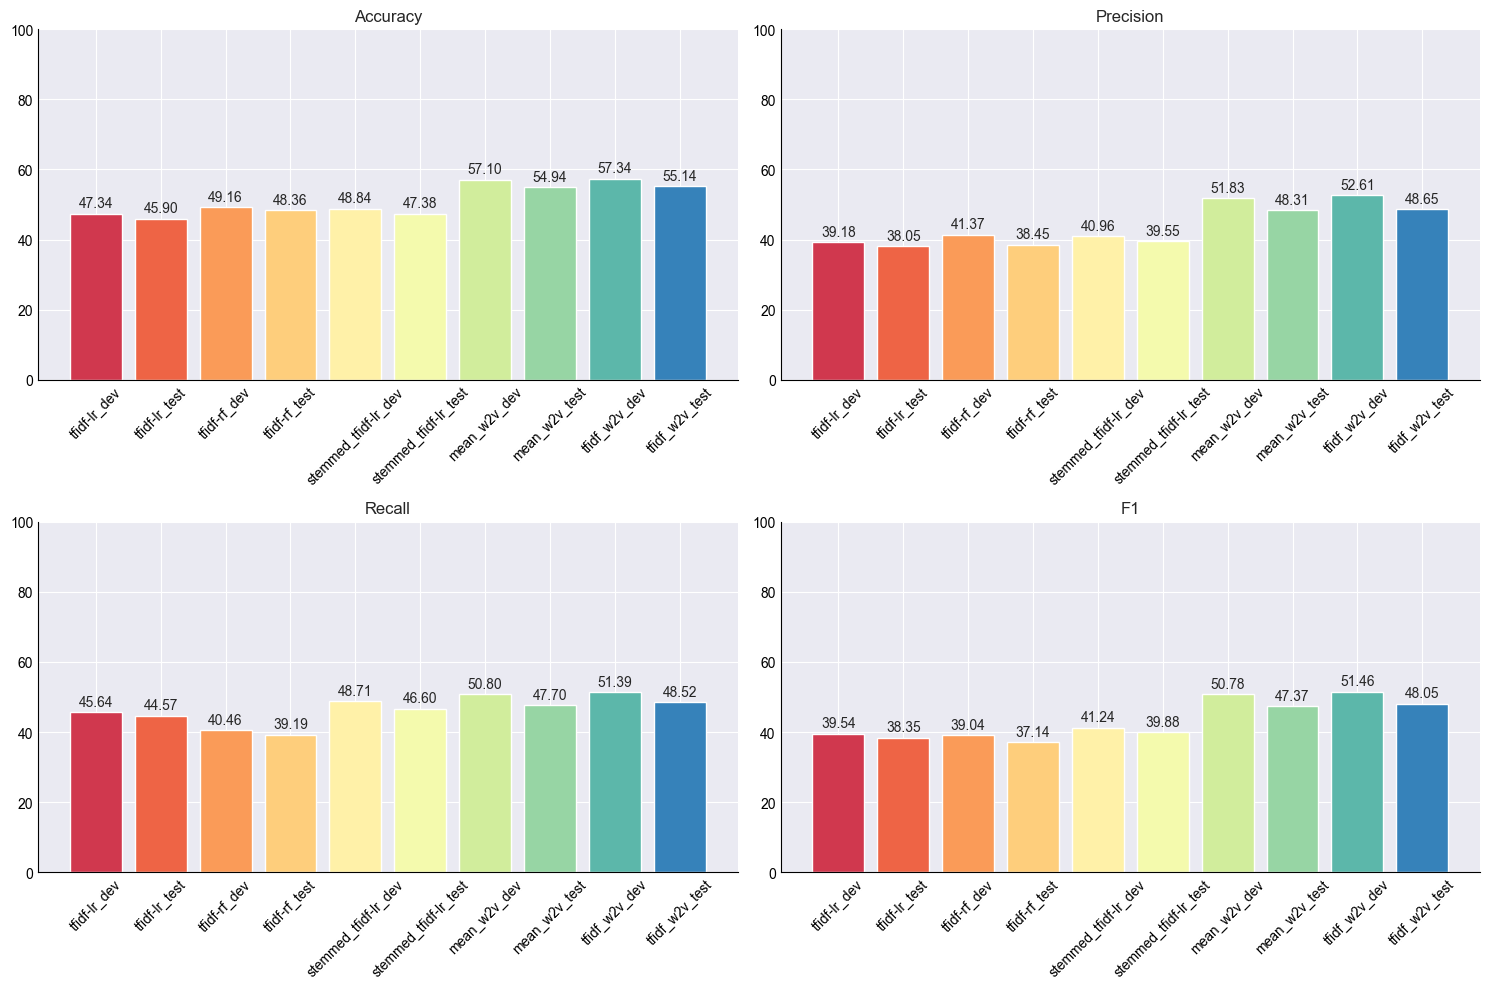

In [38]:
class TfidfEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model
        self.tfidf = TfidfVectorizer(min_df=5, max_df=0.85, ngram_range=(1,2), max_features=10000, stop_words='english')
        self.word2weight = {}

    def fit(self, X, y=None):
        self.tfidf.fit(X)
        max_idf = max(self.tfidf.idf_)
        self.word2weight = {word: self.tfidf.idf_[i]
                            for word, i in self.tfidf.vocabulary_.items()}
        self.max_idf = max_idf
        return self

    def transform(self, X):
        features = []
        for i, text in enumerate(X):
            words = text.split()
            word_vecs = []
            weights = []
            for word in words:
                vec = self.word2vec_model.embeddings([word])
                if vec is not None and len(vec) > 0:
                    weight = self.word2weight.get(word, self.max_idf)
                    word_vecs.append(vec[0])
                    weights.append(weight)
            if word_vecs:
                word_vecs = np.array(word_vecs)
                weights = np.array(weights)
                weighted_avg = np.average(word_vecs, axis=0, weights=weights)
            else:
                weighted_avg = np.zeros(self.word2vec_model.vector_size)
            features.append(weighted_avg)
        return np.array(features)


# TF-IDF weighted pipeline
tfidf_w2v_pipeline = Pipeline([
    ("cleaner", FunctionTransformer(lambda X: [remove_special_characters(text) for text in X])),
    ("tfidf_w2v", TfidfEmbeddingVectorizer(word2vec_model)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# Fit model
tfidf_w2v_pipeline.fit(df_train['text'], df_train['label'])

# Predict
y_pred_tfidfw2v_dev = tfidf_w2v_pipeline.predict(df_val['text'])
y_pred_tfidfw2v_test = tfidf_w2v_pipeline.predict(df_test['text'])

# Evaluate
results.run(df_val['label'], y_pred_tfidfw2v_dev, "tfidf_w2v_dev")
results.run(df_test['label'], y_pred_tfidfw2v_test, "tfidf_w2v_test")
results.plot()

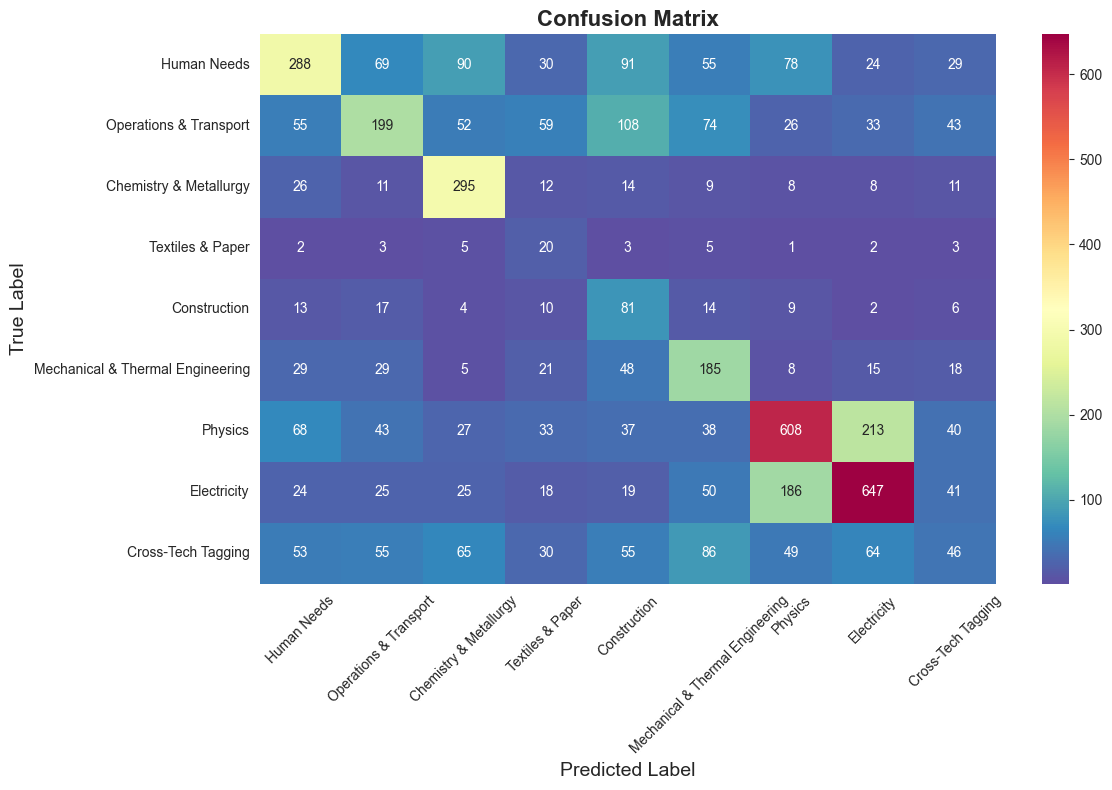

In [50]:
#plot confussion matrix for the test set
from sklearn.metrics import confusion_matrix

y_test_pred = pipeline.predict(df_test['text'])
y_test_true = df_test['label']
#map the labels to the names
label_map_int = {int(k): v for k, v in label_map.items()}

# convert predictions and true labels
y_test_true_named = [label_map_int[label] for label in y_test_true]
y_test_pred_named = [label_map_int[label] for label in y_test_pred]

# compute confusion matrix
conf_matrix = confusion_matrix(y_test_true_named, y_test_pred_named, labels=list(label_map_int.values()))

# plot
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Spectral_r',
            xticklabels=label_map_int.values(),
            yticklabels=label_map_int.values())


#add labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **4. Baseline Implementation**
---
Finally, we will develop a rule-based classifier as a baseline, where we will discuss its performance in the context of the dataset's complexity and compare it with human-level performance if available.